In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score

In [2]:
!pip install -U statsmodels

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2024-12-21 13:56:23--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: ‘perrin-freres-monthly-champagne.csv’

perrin-freres-month 100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-12-21 13:56:23 (28.7 MB/s) - ‘perrin-freres-monthly-champagne.csv’ saved [1598/1598]



In [4]:
!head perrin-freres-monthly-champagne.csv

Month,Perrin Freres monthly champagne sales millions ?64-?72
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946
1964-06,3036
1964-07,2282
1964-08,2212
1964-09,2922


In [5]:
!tail perrin-freres-monthly-champagne.csv

1972-02,3564
1972-03,4577
1972-04,4788
1972-05,4618
1972-06,5312
1972-07,4298
1972-08,1413
1972-09,5877
,
Perrin Freres monthly champagne sales millions ?64-?72,


### As you can see that there is issue with the last data points in the csv so its better to skip that

In [6]:
df = pd.read_csv(
    'perrin-freres-monthly-champagne.csv',
    index_col='Month',
    parse_dates=True,
    skipfooter = 2
)

In [7]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [8]:
df.tail

<bound method NDFrame.tail of             Perrin Freres monthly champagne sales millions ?64-?72
Month                                                             
1964-01-01                                               2815     
1964-02-01                                               2672     
1964-03-01                                               2755     
1964-04-01                                               2721     
1964-05-01                                               2946     
...                                                       ...     
1972-05-01                                               4618     
1972-06-01                                               5312     
1972-07-01                                               4298     
1972-08-01                                               1413     
1972-09-01                                               5877     

[105 rows x 1 columns]>

In [10]:
df.columns  = ["Sales"]

<Axes: xlabel='Month'>

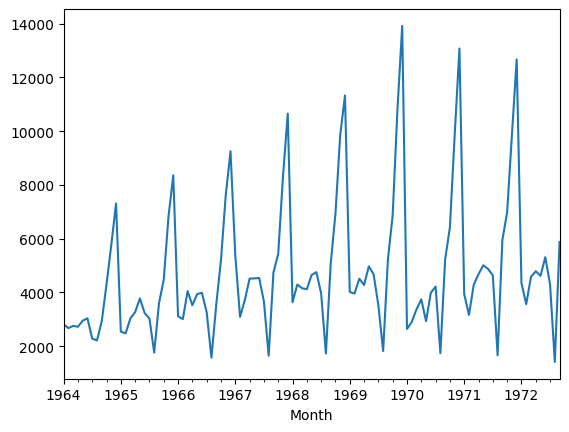

In [11]:
df.Sales.plot()

In [12]:
df.index.freq = "MS"

In [13]:
Ntest = 12
df_train = df.iloc[:-Ntest]
df_test = df.iloc[-Ntest:]


In [14]:
print(df_train.shape)
print(df_test.shape)


(93, 1)
(12, 1)


In [15]:
# boolean series to index df rows

train_idx = df.index <= df_train.index[-1]
test_idx = df.index > df_test.index[-1]

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing



In [18]:
hw  = ExponentialSmoothing(
    df_train.Sales,
    trend = 'add',
    seasonal = 'add',
    seasonal_periods = 12,
    initialization_method = 'legacy-heuristic'
)

res_hw = hw.fit()

In [19]:
df.head()


,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [20]:
print(res_hw.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   93
Model:             ExponentialSmoothing   SSE                       47208168.850
Optimized:                         True   AIC                           1253.785
Trend:                         Additive   BIC                           1294.307
Seasonal:                      Additive   AICC                          1263.029
Seasonal Periods:                    12   Date:                 Sat, 21 Dec 2024
Box-Cox:                          False   Time:                         14:09:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0757143                alpha                 True
smoothing_trend          

In [21]:
print(res_hw.fittedvalues)

Month
1964-01-01    2847.166667
1964-02-01    2733.897614
1964-03-01    2844.377034
1964-04-01    2835.775194
1964-05-01    3084.249481
                 ...     
1971-05-01    3792.457589
1971-06-01    4714.306773
1971-07-01    4646.524535
1971-08-01    2334.228442
1971-09-01    5743.250632
Freq: MS, Length: 93, dtype: float64


In [22]:
df.loc[train_idx,"HoltWintersTrain"] = res_hw.fittedvalues

In [23]:
df.head()

,Sales,HoltWintersTrain
Month,,
1964-01-01,2815,2847.166667
1964-02-01,2672,2733.897614
1964-03-01,2755,2844.377034
1964-04-01,2721,2835.775194
1964-05-01,2946,3084.249481


In [26]:
df.loc[test_idx, "HoltWintersTest"] = res_hw.forecast(Ntest)

In [27]:
df.head()

,Sales,HoltWintersTrain,HoltWintersTest
Month,,,
1964-01-01,2815,2847.166667,NaN
1964-02-01,2672,2733.897614,NaN
1964-03-01,2755,2844.377034,NaN
1964-04-01,2721,2835.775194,NaN
1964-05-01,2946,3084.249481,NaN


<Axes: xlabel='Month'>

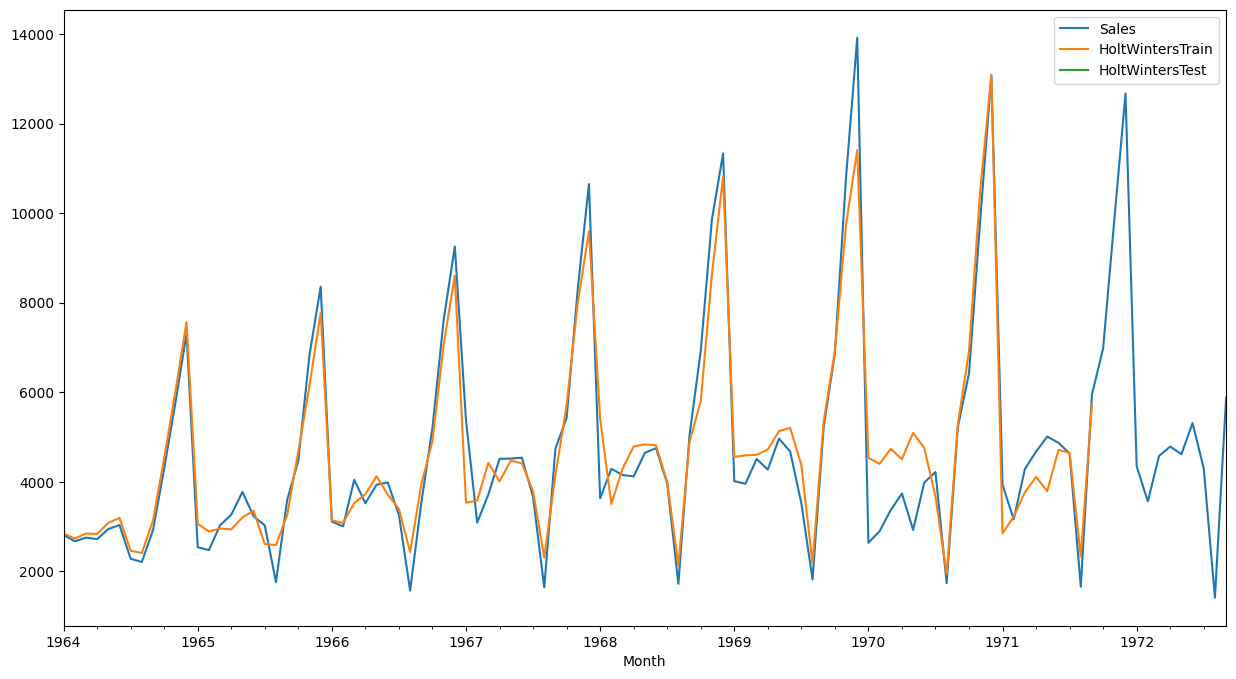

In [28]:
df[["Sales","HoltWintersTrain","HoltWintersTest"]].plot(figsize = (15,8))

In [31]:
r2_score(df_train.Sales, res_hw.fittedvalues)

0.9169984903500262

In [32]:
r2_score(df_test.Sales, res_hw.forecast(Ntest))

0.9680340910154467